In [36]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/session.json"), 'r') as file:
    session_records = json.load(file)

<AxesSubplot: xlabel='timestamp', ylabel='usdt_pnl_pct'>

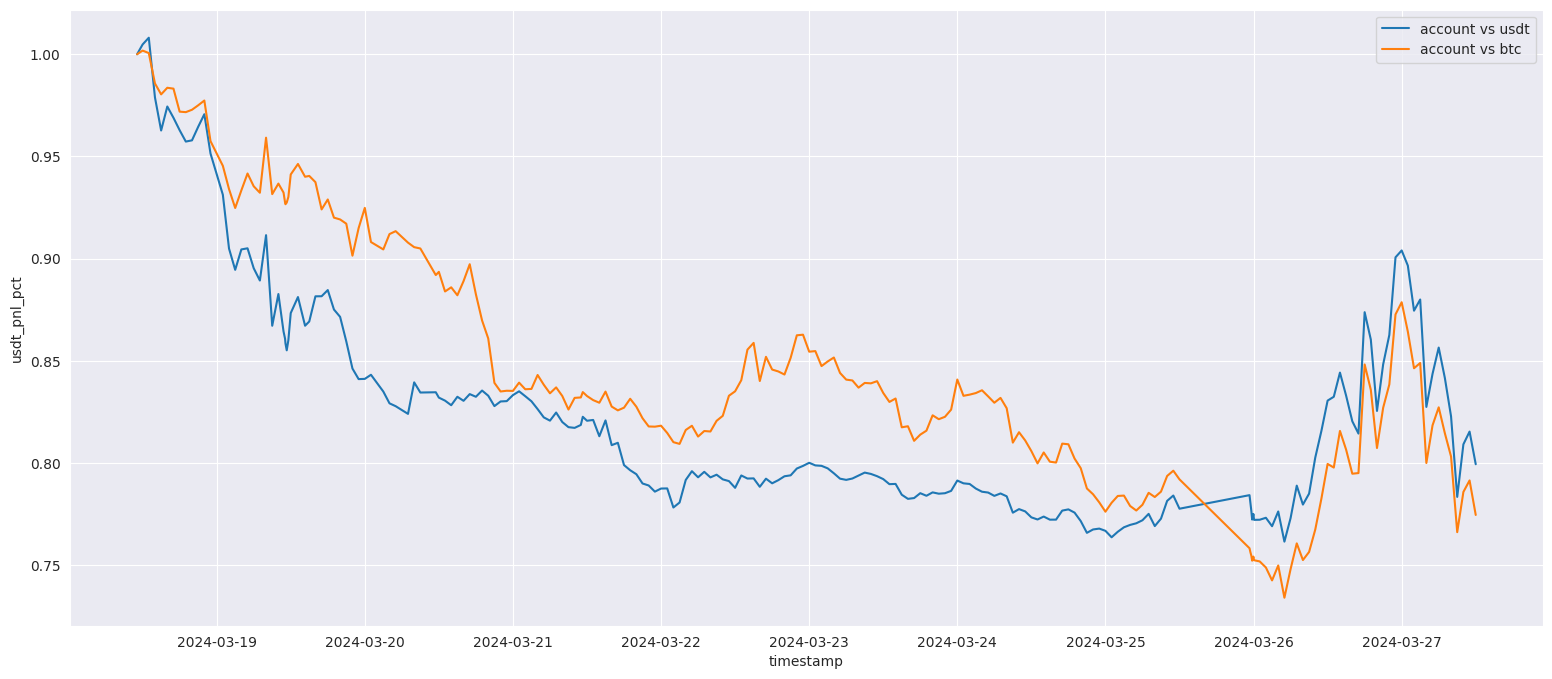

In [38]:
sr = pl.from_dicts(session_records).select(['timestamp', 'usdt_net', 'btc_net'])
sr = sr.with_columns(
    pl.col('timestamp').mul(1000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('usdt_net').truediv(sr.item(0, 'usdt_net')).alias('usdt_pnl_pct'),
    pl.col('btc_net').truediv(sr.item(0, 'btc_net')).alias('btc_pnl_pct')
)

plt.figure(figsize=(19, 8))
sns.lineplot(data=sr, x='timestamp', y='usdt_pnl_pct', label='account vs usdt')
sns.lineplot(data=sr, x='timestamp', y='btc_pnl_pct', label='account vs btc')

In [7]:
session_records

[{'timestamp': 1710075605.946023,
  'usdt_net': 2340.5250847114075,
  'btc_net': 0.03353823,
  'max_leverage': 3,
  'buffer': 0.006,
  'flat_allocations': {'BTCUSDT': 0.08872724316648388,
   'SOLUSDT': 0.07644160550574966,
   'NEARUSDT': 0.08494407590980749,
   'ROSEUSDT': 0.08242247268818789,
   'OCEANUSDT': 0.06623780739957207,
   'ETHUSDT': 0.0913627644714204,
   'MATICUSDT': 0.10744895533785517,
   'AVAXUSDT': 0.06875942845524347},
  'lin_allocations': {'BTCUSDT': 0.15773732118486022,
   'SOLUSDT': 0.11890916412005503,
   'NEARUSDT': 0.11325876787974332,
   'ROSEUSDT': 0.09158052520909767,
   'OCEANUSDT': 0.058878051021841835,
   'ETHUSDT': 0.0609085096476136,
   'MATICUSDT': 0.047755091261268964,
   'AVAXUSDT': 0.015279872990054103},
  'perf_allocations': {'BTCUSDT': 0.08492321160838869,
   'SOLUSDT': 0.08052740900659017,
   'NEARUSDT': 0.08324625744282502,
   'ROSEUSDT': 0.07282370407686256,
   'OCEANUSDT': 0.054222877531114475,
   'ETHUSDT': 0.07539005798435254,
   'MATICUSDT': 